* 이륙, 착륙 항공기, 안움직이는 항공기를 나누어야 함 
* A-CDM 파일로 기종 등 정보 가져오기
* metar에서 pressure 가져오기 -> Wheel On/Off의 기준이 되는 altitude 찾게하기
* wheel on/off 지점 지도에 찍기??

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta
import re
import math
import seaborn as sns

In [2]:
# options
pd.set_option('max_columns',100)
warnings.simplefilter('ignore')
plt.style.use('fivethirtyeight')

In [3]:
save_dir = '../result/notebook/'

# 내꺼

In [ ]:
# initialize
absolute_difference = lambda datalist : abs(datalist - pressure_altitude)

to = pd.DataFrame()
ld = pd.DataFrame()
others = pd.DataFrame()

In [ ]:
# load data
daterange = pd.date_range(start='12/21/2019 15:00', end='12/28/2019 14:00', freq='1H').strftime('%Y%m%d_%H%M%S')
date = daterange[0]
print(date)
df = pd.read_csv(f'../input/MLAT/tp1_{date}_Cat20.ast_Mlat.csv', index_col=False, header = 1)

# 여기서 date를 concat하면 같은 c/s인 항공기가 있어서 안 좋을 것 같음 -> 가장 큰 for loop으로 쓰기
# for date in daterange:
#    df = pd.read_csv(f'../input/tp1_{i}_Cat20.ast_Mlat.csv', index_col=False, header = 1)

In [ ]:
# calculate pressure altitude
current_pressure = float(input('Current pressure : '))
fe_m = 7
msl_ft = 145366.45 * (1 - (current_pressure/1013.25)**0.190284)
msl_m = msl_ft * 0.3048
pressure_altitude = msl_m + fe_m
print('RKSI Field Elevation : 7 m')
print(f'Pressure Altitude : {pressure_altitude} m')

In [ ]:
# Wheel On/Off 지점 찾기

ident = np.unique(df['ModeSIdent'].values).tolist()


for i in ident:
    # c/s별로 wheel on/off 지점인 데이터만 넣기
    temp_df = df[df['ModeSIdent'] == i]
    temp_df['BAlt'] = temp_df['BAlt'].replace('----', 10000).astype(float)         # '----'값은 의미없도록 10000으로 바꿈
    temp_altitude_list = temp_df['BAlt']
    temp_closest_value = min(temp_altitude_list, key = absolute_difference)        # absolute_difference 으로 가장 가까운 값 찾기
    temp_df = temp_df[temp_df['BAlt'] == temp_closest_value]
    
    # ops로 arr / dep나누기
    if temp_df['GroudSpeed'].iloc[0] < temp_df['GroudSpeed'].iloc[-1]:
        temp_df['ops'] = 'departure'
    elif temp_df['GroudSpeed'].iloc[0] > temp_df['GroudSpeed'].iloc[-1]:
        temp_df['ops'] = 'arrival'
    else:
        temp_df['ops'] = 'others'
    
    # arr / dep 각각 저장 - # landing은 0, takeoff는 -1로 해야함
    if abs(temp_df['BAlt'].iloc[0] - pressure_altitude) > 100:    # 너무 큰 이상한 것은 버림
        others = others.append(temp_df)
    elif (temp_df['ops'].iloc[0] == 'departure') & (temp_df['GroudSpeed'].iloc[-1] > 50):    
        to = to.append(temp_df.iloc[-1,:])    
    elif (temp_df['ops'].iloc[0] == 'arrival') & (temp_df['GroudSpeed'].iloc[0] > 50):
        ld = ld.append(temp_df.iloc[0,:])
    else:
        others = others.append(temp_df)

In [ ]:
base_map = plt.imread('../data/map.png')
BBox = (126.3940, 126.4743, 37.4414, 37.4856)

fig, ax = plt.subplots(figsize = (25,20))
ax.scatter(to['Longitude'], to['Latitude'], alpha= 0.6, c='b', s=15, marker = 'o')
ax.scatter(ld['Longitude'], ld['Latitude'], alpha= 0.6, c='r', s=15, marker = 'x')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(base_map, zorder = 0, extent = BBox, aspect= 'equal')

In [ ]:
to



# 교수님 데이터

## 기본

In [4]:
columns = ['Time', 'Callsign', 'AC', 'Lat', 'Lon', 'RWY', 'DIST']

# RWY : '33L', '33R', 34, '15R', '15L', 16  -->>  1-3 : Northflow / 4-6 : Southflow

In [5]:
arr_df = pd.read_csv(f'../input/arr_data.csv', index_col=False, header = 0)
dep_df = pd.read_csv(f'../input/dep_data.csv', index_col=False, header = 0)

In [6]:
arr_df.columns = columns
dep_df.columns = columns
arr_df['Time']= pd.to_datetime(arr_df['Time'])
dep_df['Time']= pd.to_datetime(dep_df['Time'])

In [7]:
base_map = plt.imread('../data/map.png')
BBox = (126.3940, 126.4743, 37.4414, 37.4856)

arr_df_north = arr_df[arr_df['RWY'] <= 3]
dep_df_north = dep_df[dep_df['RWY'] <= 3]
arr_df_south = arr_df[arr_df['RWY'] > 3]
dep_df_south = dep_df[dep_df['RWY'] > 3]

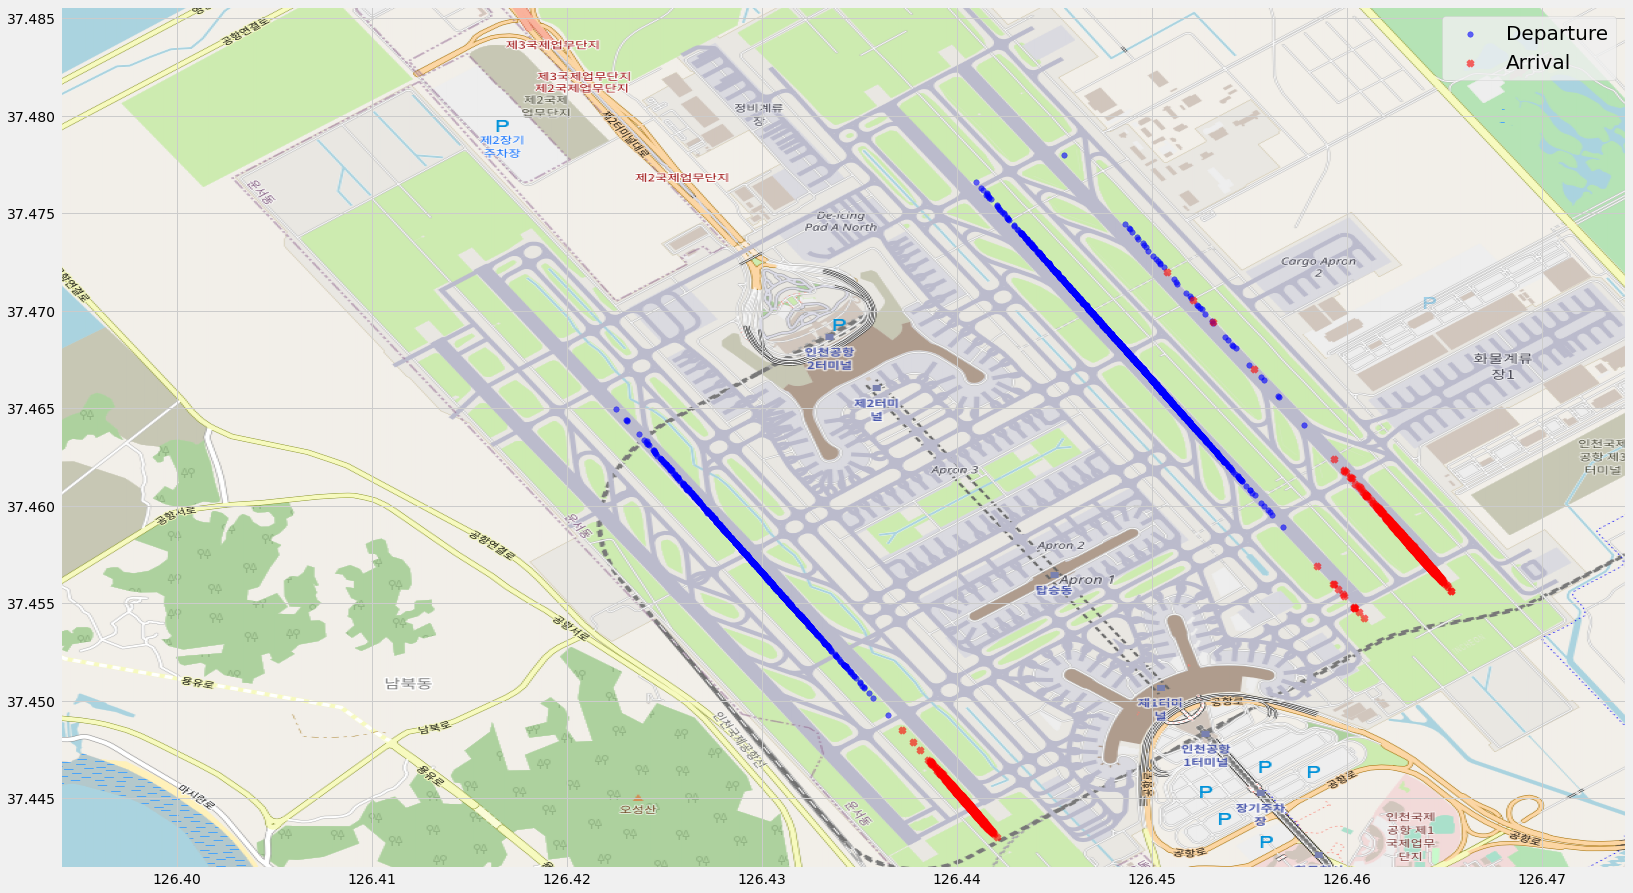

In [8]:
# North flow

fig, ax = plt.subplots(figsize = (25,20))
ax.scatter(dep_df_north['Lon'], dep_df_north['Lat'], alpha= 0.6, c='b', s=30, marker = 'o', label = 'Departure')
ax.scatter(arr_df_north['Lon'], arr_df_north['Lat'], alpha= 0.6, c='r', s=30, marker = 'x', label = 'Arrival')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.legend(fontsize=20)
ax.imshow(base_map, zorder = 0, extent = BBox, aspect= 'equal')

plt.savefig(save_dir + 'northflow.png', bbox_inches='tight', pad_inches=1)

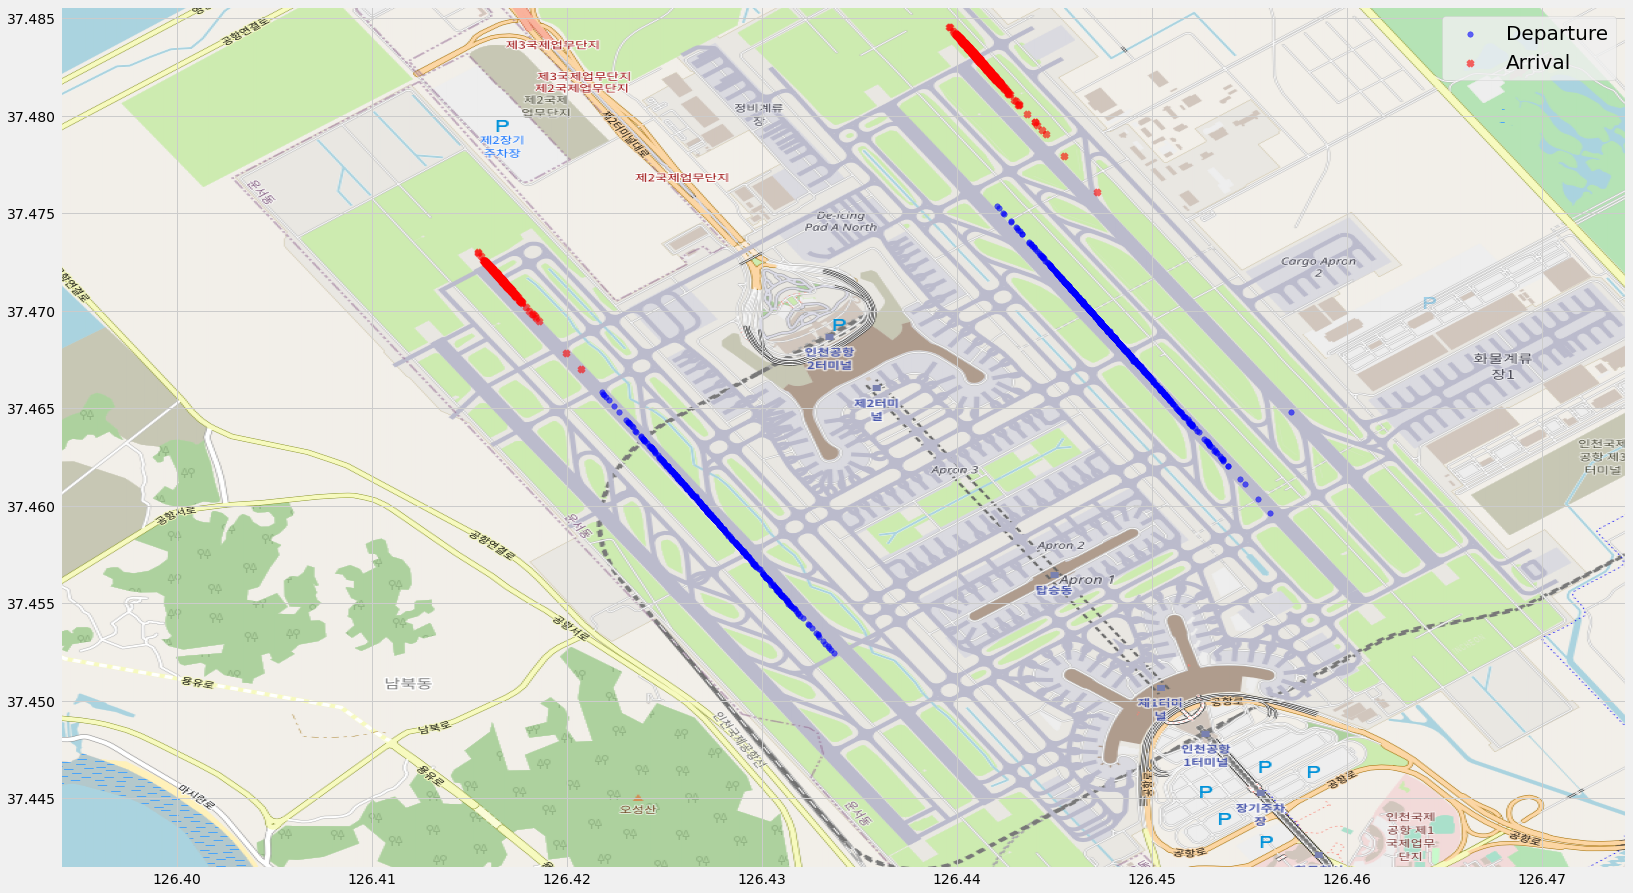

In [9]:
# South flow
fig, ax = plt.subplots(figsize = (25,20))
ax.scatter(dep_df_south['Lon'], dep_df_south['Lat'], alpha= 0.6, c='b', s=30, marker = 'o', label = 'Departure')
ax.scatter(arr_df_south['Lon'], arr_df_south['Lat'], alpha= 0.6, c='r', s=30, marker = 'x', label = 'Arrival')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.legend(fontsize=20)
ax.imshow(base_map, zorder = 0, extent = BBox, aspect= 'equal')

plt.savefig(save_dir + 'southflow.png', bbox_inches='tight', pad_inches=1)

In [10]:
labels1 = [ 'mean', '33L', '33R', '34']
labels2 = [ 'mean', '15R', '15L', '16']

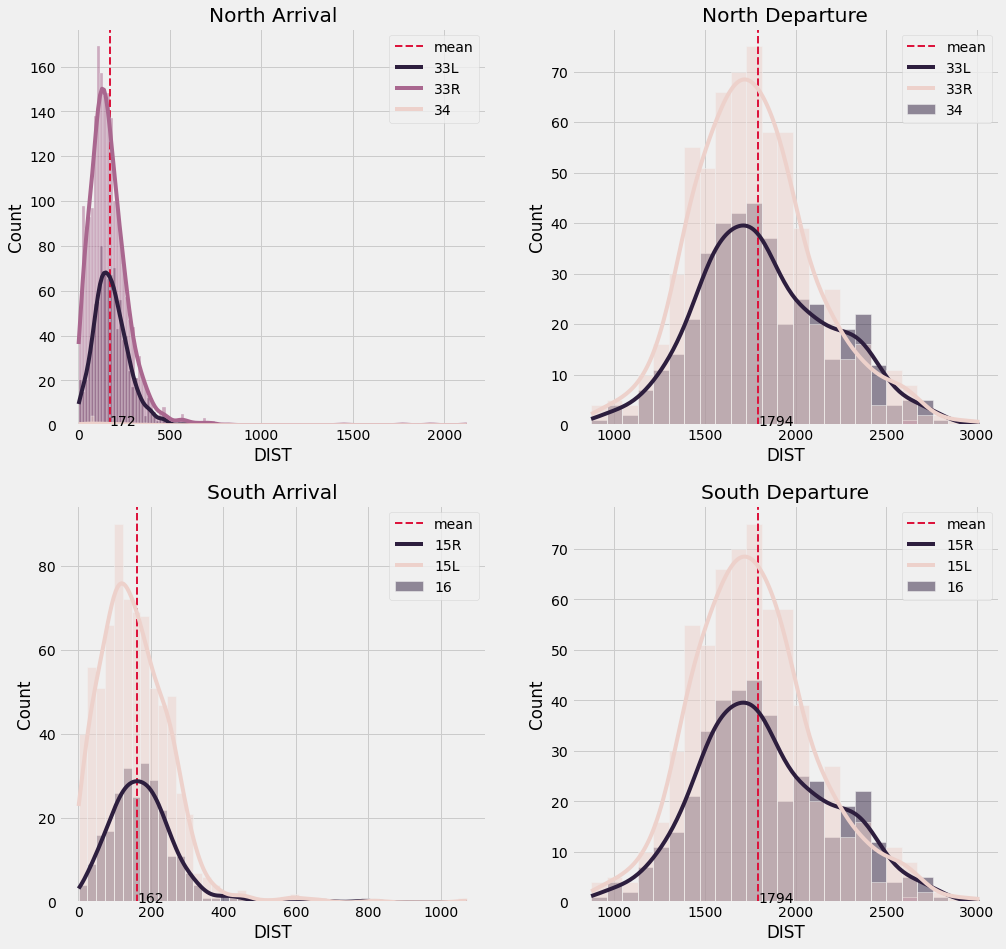

In [11]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plt.axvline(np.mean(arr_df_north['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = arr_df_north, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(arr_df_north['DIST'])), 
             xy = (np.mean(arr_df_north['DIST']), 10),
             xytext = (np.mean(arr_df_north['DIST']), 0))
plt.legend(labels = labels1)
plt.title('North Arrival')

plt.subplot(2,2,2)
plt.axvline(np.mean(dep_df_south['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south['DIST'])), 
             xy = (np.mean(dep_df_south['DIST']), 10),
             xytext = (np.mean(dep_df_south['DIST']), 0))
plt.legend(labels = labels1)
plt.title('North Departure')

plt.subplot(2,2,3)
plt.axvline(np.mean(arr_df_south['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = arr_df_south, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(arr_df_south['DIST'])), 
             xy = (np.mean(arr_df_south['DIST']), 10),
             xytext = (np.mean(arr_df_south['DIST']), 0))
plt.legend(labels = labels2)
plt.title('South Arrival')

plt.subplot(2,2,4)
plt.axvline(np.mean(dep_df_south['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south['DIST'])), 
             xy = (np.mean(dep_df_south['DIST']), 10),
             xytext = (np.mean(dep_df_south['DIST']), 0))
plt.legend(labels = labels2)
plt.title('South Departure')

plt.savefig(save_dir + 'entire_dist.png', bbox_inches='tight', pad_inches=1)

***
***
***

## Aircraft Type

payload를 알 수 있다면 gross weight으로 적용하고, 더 정확할 듯

<b>FAA Order JO 7360.1E Aircraft Type Designators</b> <br>
RECAT 2.0 Wake Category apdx.B <br>

(1) Category A – Upper Heavy Aircraft <br>
(2) Category B – Lower Heavy Aircraft <br>
(3) Category C – Upper Large Aircraft <br>
(4) Category D – Lower Large Aircraft <br>
(5) Category E – Small Plus aircraft with a maximum takeoff weight of more than 15,400 pounds up to 41,000 pounds <br>
(6) Category F – Small aircraft with a maximum takeoff weight of 15,400 pounds or less <br>
(7) Category G – Heavy aircraft not included in Category A or B <br>

In [12]:
# dep_df_south['AC'].value_counts()

In [13]:
mapping = {'B738':'C', 'A321':'C', 'A333':'A', 'A320':'C', 'B772':'A', 'B77W':'A', 'B744':'A',
           'B748':'A', 'A359':'A', 'B739':'C', 'A332':'A', 'B789':'A', 'A21N':'C', 'B763':'B',
           'B773':'A', 'B77L':'A', 'B737':'C', 'B788':'A', 'A20N':'C', 'A319':'C', 'B787':'A',
           'A339':'G', 'B767':'B', 'MD11':'B', 'B78X':'G', 'A306':'C', 'B747':'A', 'A330':'A', 
           'B752':'C', 'B777':'A', 'A124':'G', 'A388':'NOWGT', 'A380':'NOWGT'}

In [14]:
# 기종에서 무게 구분으로 바꾸기
dep_df_north.loc[:,'AC'] = dep_df_north['AC'].map(mapping)
dep_df_south.loc[:,'AC'] = dep_df_south['AC'].map(mapping)

In [15]:
dep_df_south_A = dep_df_south[dep_df_south['AC'] == 'A']
dep_df_south_B = dep_df_south[dep_df_south['AC'] == 'B']
dep_df_south_C = dep_df_south[dep_df_south['AC'] == 'C']
dep_df_south_G = dep_df_south[dep_df_south['AC'] == 'G']
dep_df_south_NOWGT = dep_df_south[dep_df_south['AC'] == 'NOWGT']

dep_df_north_A = dep_df_north[dep_df_north['AC'] == 'A']
dep_df_north_B = dep_df_north[dep_df_north['AC'] == 'B']
dep_df_north_C = dep_df_north[dep_df_north['AC'] == 'C']
dep_df_north_G = dep_df_north[dep_df_north['AC'] == 'G']
dep_df_north_NOWGT = dep_df_north[dep_df_north['AC'] == 'NOWGT']

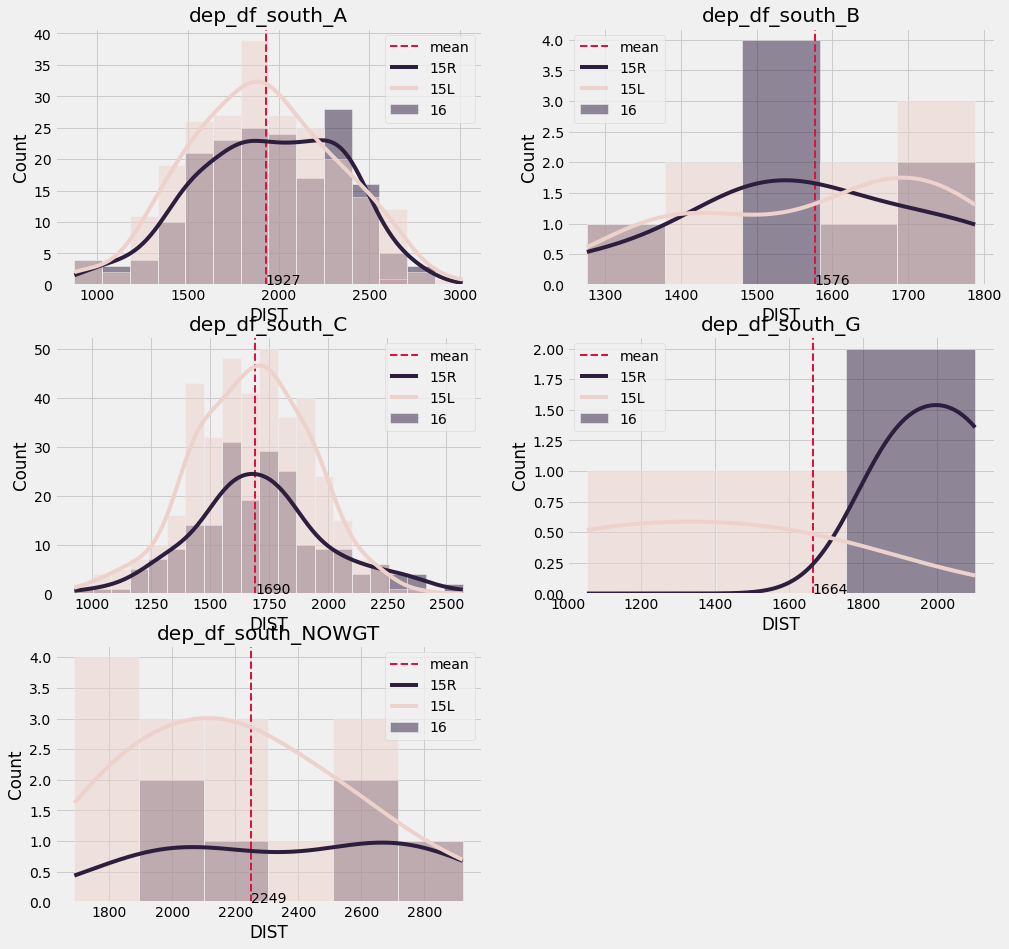

In [16]:
# South

plt.figure(figsize=(15, 15))

plt.subplot(3,2,1)
plt.axvline(np.mean(dep_df_south_A['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_A, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_A['DIST'])), 
             xy = (np.mean(dep_df_south_A['DIST']), 10),
             xytext = (np.mean(dep_df_south_A['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_A')

plt.subplot(3,2,2)
plt.axvline(np.mean(dep_df_south_B['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_B, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_B['DIST'])), 
             xy = (np.mean(dep_df_south_B['DIST']), 1),
             xytext = (np.mean(dep_df_south_B['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_B')

plt.subplot(3,2,3)
plt.axvline(np.mean(dep_df_south_C['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_C, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_C['DIST'])), 
             xy = (np.mean(dep_df_south_C['DIST']), 10),
             xytext = (np.mean(dep_df_south_C['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_C')

plt.subplot(3,2,4)
plt.axvline(np.mean(dep_df_south_G['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_G, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_G['DIST'])), 
             xy = (np.mean(dep_df_south_G['DIST']), 1),
             xytext = (np.mean(dep_df_south_G['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_G')

plt.subplot(3,2,5)
plt.axvline(np.mean(dep_df_south_NOWGT['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_NOWGT, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_NOWGT['DIST'])), 
             xy = (np.mean(dep_df_south_NOWGT['DIST']), 1),
             xytext = (np.mean(dep_df_south_NOWGT['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_NOWGT')

plt.savefig(save_dir + 'weight_dist_south.png', bbox_inches='tight', pad_inches=1)

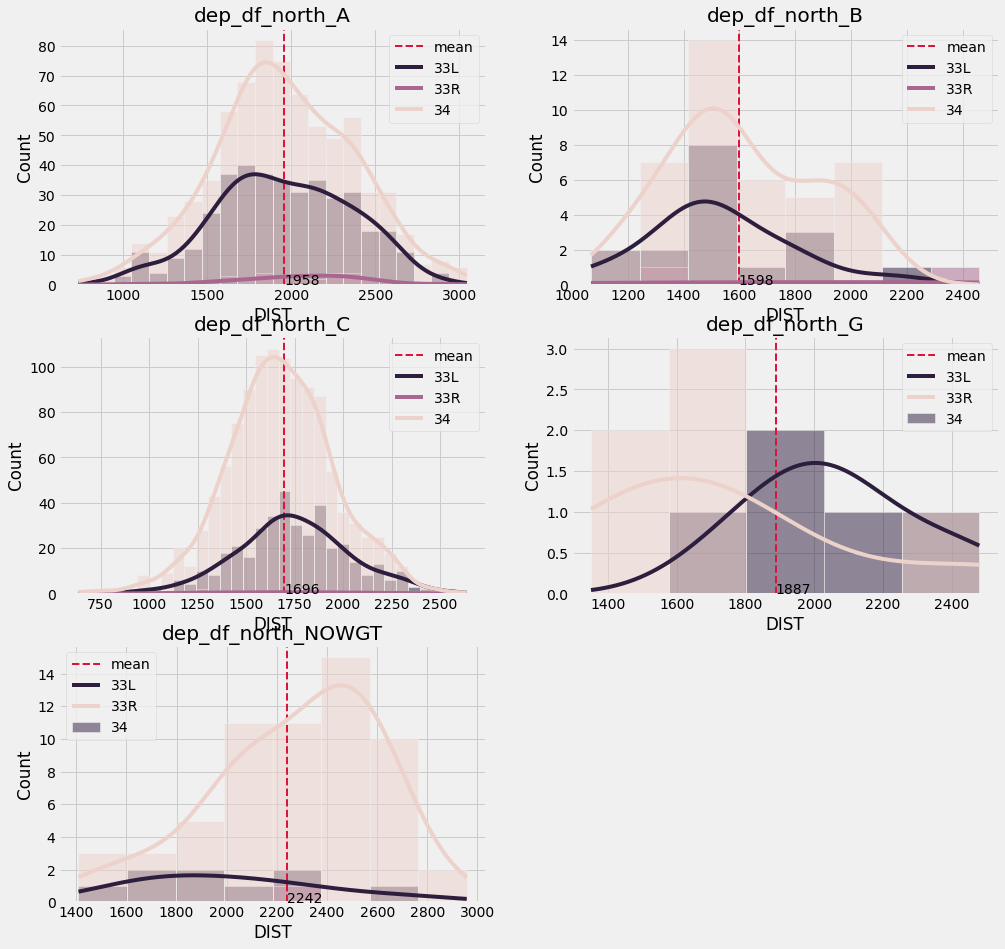

In [17]:
# North

plt.figure(figsize=(15, 15))

plt.subplot(3,2,1)
plt.axvline(np.mean(dep_df_north_A['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_A, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_A['DIST'])), 
             xy = (np.mean(dep_df_north_A['DIST']), 10),
             xytext = (np.mean(dep_df_north_A['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_A')

plt.subplot(3,2,2)
plt.axvline(np.mean(dep_df_north_B['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_B, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_B['DIST'])), 
             xy = (np.mean(dep_df_north_B['DIST']), 1),
             xytext = (np.mean(dep_df_north_B['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_B')

plt.subplot(3,2,3)
plt.axvline(np.mean(dep_df_north_C['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_C, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_C['DIST'])), 
             xy = (np.mean(dep_df_north_C['DIST']), 10),
             xytext = (np.mean(dep_df_north_C['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_C')

plt.subplot(3,2,4)
plt.axvline(np.mean(dep_df_north_G['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_G, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_G['DIST'])), 
             xy = (np.mean(dep_df_north_G['DIST']), 1),
             xytext = (np.mean(dep_df_north_G['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_G')

plt.subplot(3,2,5)
plt.axvline(np.mean(dep_df_north_NOWGT['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_NOWGT, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_NOWGT['DIST'])), 
             xy = (np.mean(dep_df_north_NOWGT['DIST']), 1),
             xytext = (np.mean(dep_df_north_NOWGT['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_NOWGT')

plt.savefig(save_dir + 'weight_dist_north.png', bbox_inches='tight', pad_inches=1)

***
***
***
## METAR

In [18]:
metar_df = pd.read_csv(f'../input/metar_20191222-20191228.csv', index_col=False, header = 0)
metar_df['IssueTime'] = pd.to_datetime(metar_df['IssueTime'])

In [19]:
dep_df['DensityAltitude'] = 0
dep_df['Headwind'] = 0
dep_df['Wet'] = 0

In [20]:
for i in range(len(metar_df)-1):
    dep_df.loc[dep_df['Time'] >= metar_df['IssueTime'][i], 'DensityAltitude'] = metar_df['DensityAltitude'][i]
    dep_df.loc[dep_df['Time'] >= metar_df['IssueTime'][i], 'Headwind'] = metar_df['Headwind'][i]
    dep_df.loc[dep_df['Time'] >= metar_df['IssueTime'][i], 'Wet'] = metar_df['Wet'][i]

In [21]:
dep_df_north = dep_df[dep_df['RWY'] <= 3]
dep_df_south = dep_df[dep_df['RWY'] > 3]
dep_df_north.loc[:,'AC'] = dep_df_north['AC'].map(mapping)
dep_df_south.loc[:,'AC'] = dep_df_south['AC'].map(mapping)

In [22]:
dep_df_north.describe()

Lat          Lon          RWY         DIST  DensityAltitude  \
count  2853.000000  2853.000000  2853.000000  2853.000000      2853.000000   
mean     37.464492   126.443559     1.587802  1814.680541     -1853.525569   
std       0.005506     0.009158     0.903332   371.308817       407.245310   
min      37.449265   126.422516     1.000000   635.674857     -2656.348237   
25%      37.460214   126.432193     1.000000  1568.060791     -2182.371726   
50%      37.465965   126.448190     1.000000  1778.142828     -1866.010659   
75%      37.468164   126.450185     3.000000  2041.208347     -1537.301346   
max      37.477954   126.457792     3.000000  3043.692424      -934.955779   

          Headwind          Wet  
count  2853.000000  2853.000000  
mean      4.961864     0.064494  
std       4.328534     0.245673  
min       0.162485     0.000000  
25%       1.302920     0.000000  
50%       3.615136     0.000000  
75%       7.270397     0.000000  
max      17.414004     1.000000

In [23]:
dep_df_south.describe()

Lat          Lon          RWY         DIST  DensityAltitude  \
count  1054.000000  1054.000000  1054.000000  1054.000000      1054.000000   
mean     37.465134   126.440048     4.773245  1793.994903     -1642.861833   
std       0.005266     0.010205     0.973927   353.392055       370.849785   
min      37.452452   126.421791     4.000000   872.645999     -2592.547402   
25%      37.460551   126.428070     4.000000  1554.427284     -1864.440661   
50%      37.466796   126.445931     4.000000  1756.549122     -1667.392783   
75%      37.469461   126.448171     6.000000  2005.207899     -1418.258989   
max      37.475379   126.457148     6.000000  3013.699040      -913.634402   

          Headwind          Wet  
count  1054.000000  1054.000000  
mean      6.744695     0.086338  
std       4.273354     0.280995  
min       0.162485     0.000000  
25%       2.274822     0.000000  
50%       7.739557     0.000000  
75%       9.956600     0.000000  
max      13.939240     1.000000

### Density Altitude

DA는 Northflow, South flow 모두 max -900 정도로 낮은 DA를 보임 -> 50% 지점에서 나누어도 큰 의미 없음

In [24]:
dep_df_north_highDA = dep_df_north[dep_df_north['DensityAltitude'] >= -1866.010659]
dep_df_north_lowDA = dep_df_north[dep_df_north['DensityAltitude'] < -1866.010659]
dep_df_south_highDA = dep_df_south[dep_df_south['DensityAltitude'] >= -1866.010659]
dep_df_south_lowDA = dep_df_south[dep_df_south['DensityAltitude'] < -1866.010659]

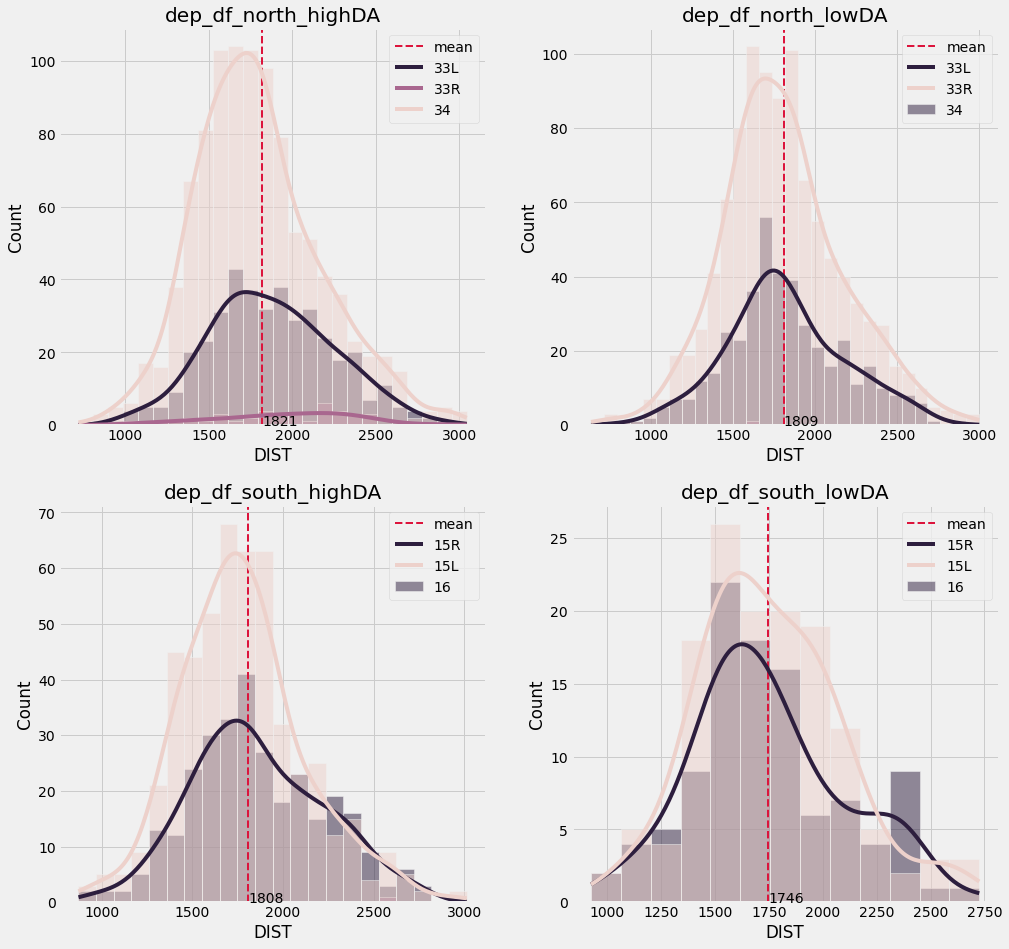

In [25]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plt.axvline(np.mean(dep_df_north_highDA['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_highDA, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_highDA['DIST'])), 
             xy = (np.mean(dep_df_north_highDA['DIST']), 10),
             xytext = (np.mean(dep_df_north_highDA['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_highDA')

plt.subplot(2,2,2)
plt.axvline(np.mean(dep_df_north_lowDA['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_lowDA, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_lowDA['DIST'])), 
             xy = (np.mean(dep_df_north_lowDA['DIST']), 10),
             xytext = (np.mean(dep_df_north_lowDA['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_lowDA')

plt.subplot(2,2,3)
plt.axvline(np.mean(dep_df_south_highDA['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_highDA, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_highDA['DIST'])), 
             xy = (np.mean(dep_df_south_highDA['DIST']), 10),
             xytext = (np.mean(dep_df_south_highDA['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_highDA')

plt.subplot(2,2,4)
plt.axvline(np.mean(dep_df_south_lowDA['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_lowDA, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_lowDA['DIST'])), 
             xy = (np.mean(dep_df_south_lowDA['DIST']), 10),
             xytext = (np.mean(dep_df_south_lowDA['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_lowDA')

plt.savefig(save_dir + 'densityaltitude_dist.png', bbox_inches='tight', pad_inches=1)

### Headwind

In [26]:
# 10kts기준

dep_df_north_highHW = dep_df_north[dep_df_north['Headwind'] >= 10]
dep_df_north_lowHW = dep_df_north[dep_df_north['Headwind'] < 10]
dep_df_south_highHW = dep_df_south[dep_df_south['Headwind'] >= 10]
dep_df_south_lowHW = dep_df_south[dep_df_south['Headwind'] < 10]

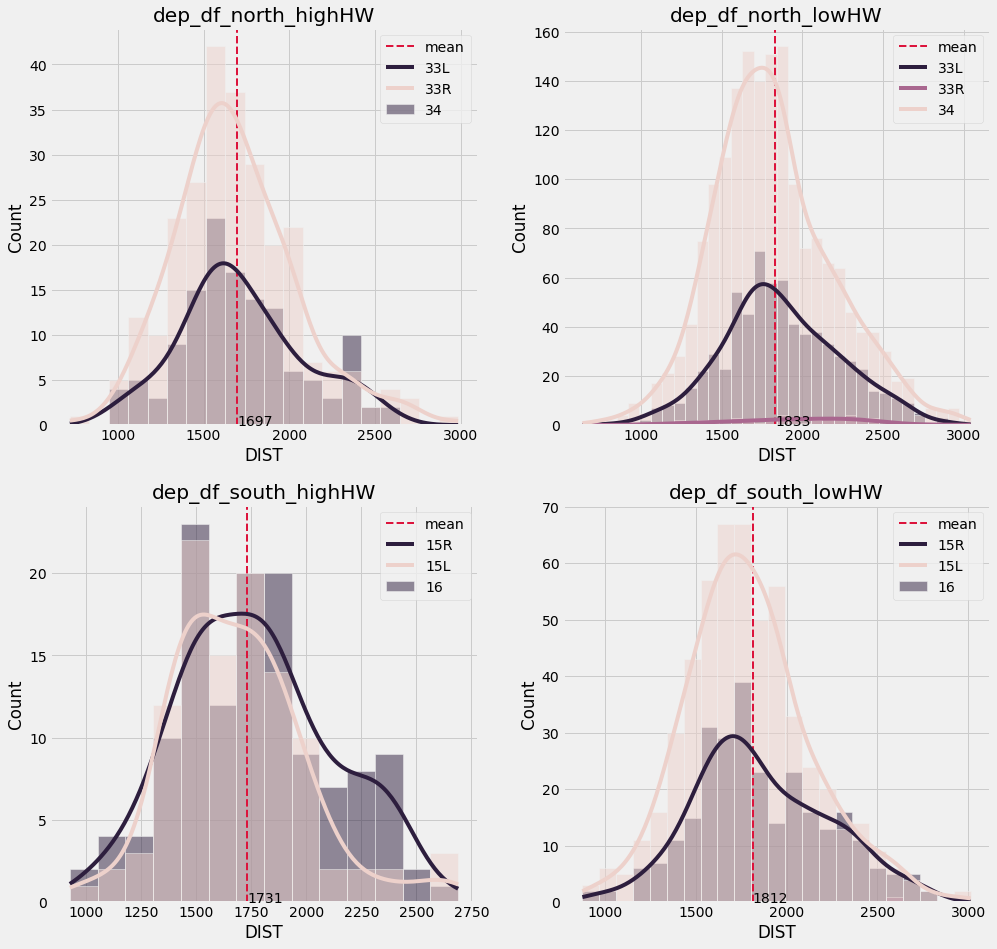

In [27]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plt.axvline(np.mean(dep_df_north_highHW['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_highHW, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_highHW['DIST'])), 
             xy = (np.mean(dep_df_north_highHW['DIST']), 10),
             xytext = (np.mean(dep_df_north_highHW['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_highHW')

plt.subplot(2,2,2)
plt.axvline(np.mean(dep_df_north_lowHW['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_lowHW, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_lowHW['DIST'])), 
             xy = (np.mean(dep_df_north_lowHW['DIST']), 10),
             xytext = (np.mean(dep_df_north_lowHW['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_lowHW')

plt.subplot(2,2,3)
plt.axvline(np.mean(dep_df_south_highHW['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_highHW, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_highHW['DIST'])), 
             xy = (np.mean(dep_df_south_highHW['DIST']), 10),
             xytext = (np.mean(dep_df_south_highHW['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_highHW')

plt.subplot(2,2,4)
plt.axvline(np.mean(dep_df_south_lowHW['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_lowHW, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_lowHW['DIST'])), 
             xy = (np.mean(dep_df_south_lowHW['DIST']), 10),
             xytext = (np.mean(dep_df_south_lowHW['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_lowHW')

plt.savefig(save_dir + 'headwind_dist.png', bbox_inches='tight', pad_inches=1)

### Runway Condition

In [28]:
dep_df_north_Wet= dep_df_north[dep_df_north['Wet'] == 1]
dep_df_north_notWet = dep_df_north[dep_df_north['Wet'] == 0]
dep_df_south_Wet = dep_df_south[dep_df_south['Wet'] == 1]
dep_df_south_notWet = dep_df_south[dep_df_south['Wet'] == 0]

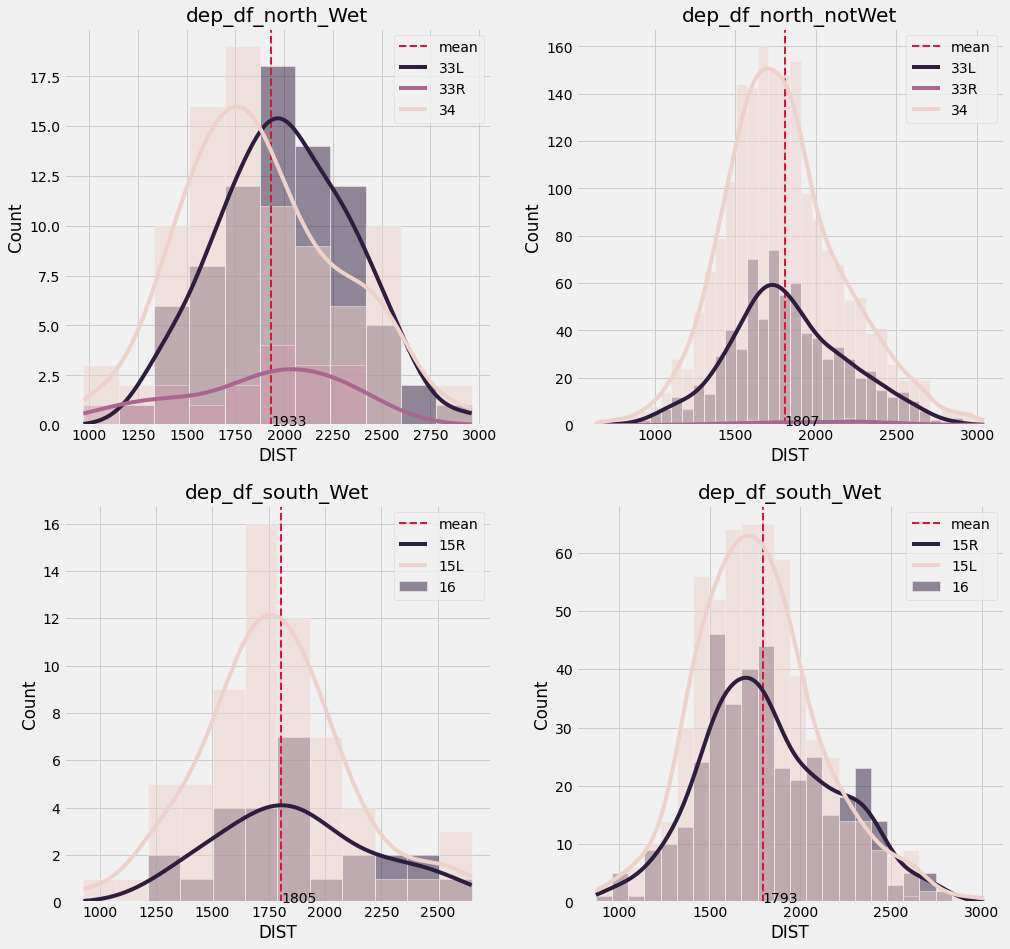

In [29]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plt.axvline(np.mean(dep_df_north_Wet['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_Wet, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_Wet['DIST'])), 
             xy = (np.mean(dep_df_north_Wet['DIST']), 10),
             xytext = (np.mean(dep_df_north_Wet['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_Wet')

plt.subplot(2,2,2)
plt.axvline(np.mean(dep_df_north_notWet['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_north_notWet, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_north_notWet['DIST'])), 
             xy = (np.mean(dep_df_north_notWet['DIST']), 10),
             xytext = (np.mean(dep_df_north_notWet['DIST']), 0))
plt.legend(labels = labels1)
plt.title('dep_df_north_notWet')

plt.subplot(2,2,3)
plt.axvline(np.mean(dep_df_south_Wet['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_Wet, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_Wet['DIST'])), 
             xy = (np.mean(dep_df_south_Wet['DIST']), 10),
             xytext = (np.mean(dep_df_south_Wet['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_Wet')

plt.subplot(2,2,4)
plt.axvline(np.mean(dep_df_south_notWet['DIST']), color='crimson', linestyle = '--', linewidth = 2)
sns.histplot(data = dep_df_south_notWet, x="DIST", kde=True, hue="RWY", multiple='layer')
plt.annotate(round(np.mean(dep_df_south_notWet['DIST'])), 
             xy = (np.mean(dep_df_south_notWet['DIST']), 10),
             xytext = (np.mean(dep_df_south_notWet['DIST']), 0))
plt.legend(labels = labels2)
plt.title('dep_df_south_Wet')

plt.savefig(save_dir + 'rwycondition_dist.png', bbox_inches='tight', pad_inches=1)

## ML??

In [30]:
dep_df_north

Time Callsign     AC        Lat         Lon  RWY  \
0    2019-12-22 00:07:50   AAR286      A  37.473963  126.443303    1   
1    2019-12-22 00:06:06  AAR3233      C  37.472761  126.444381    1   
2    2019-12-22 00:13:34   AAR383      A  37.469516  126.447278    1   
3    2019-12-22 00:20:54   ABL319      C  37.468073  126.448528    1   
4    2019-12-22 00:19:01  APG7047      C  37.467987  126.448603    1   
...                  ...      ...    ...        ...         ...  ...   
3355 2019-12-28 00:39:09   XAX509      A  37.468738  126.447954    1   
3357 2019-12-28 01:04:19  CDG4722      C  37.463851  126.452304    1   
3359 2019-12-28 01:06:31   CEB187      A  37.469140  126.447583    1   
3360 2019-12-28 01:00:19   ETD873  NOWGT  37.474038  126.443238    1   
3367 2019-12-28 01:02:37   TAX703      A  37.468598  126.448093    1   

             DIST  DensityAltitude  Headwind  Wet  
0     2685.198853     -1701.232595  5.804668    0  
1     2521.239247     -1701.232595  5.804668    0  
2     2079.188465     -1701.232595  5.804668    0  
3     1884.586624     -1701.232595  5.804668    0  
4     1872.972673     -1701.232595  5.804668    0  
...           ...              ...       ...  ...  
3355  1974.180366     -2336.303266  4.543998    0  
3357  1309.115874     -2332.345713  4.983472    0  
3359  2029.545125     -2332.345713  4.983472    0  
3360  2695.291602     -2332.345713  4.983472    0  
3367  1954.415995     -2332.345713  4.983472    0  

[2853 rows x 10 columns]

In [ ]:
# ground speed를 가져오면 도움이 될까?

## Sensitivity Analysis

In [58]:
import statistics

In [60]:
for i in list(set(dep_df_north['AC'].values))[1:]:
    print(f'{str(i)} : ' , statistics.stdev(dep_df_north[dep_df_north['AC'] == i]['DIST']))    # 무게별로 sd


G :  358.6368667735189
A :  407.9127126617789
B :  283.1465729964221
C :  281.14835288722657
NOWGT :  348.4772579313089


<AxesSubplot:xlabel='Headwind', ylabel='DIST'>

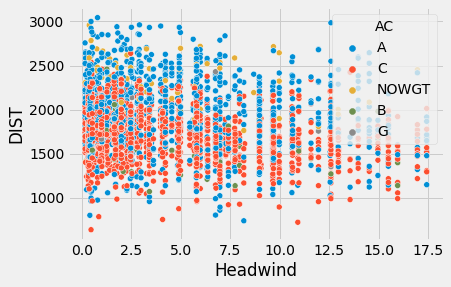

In [35]:
sns.scatterplot(data=dep_df_north, x="Headwind", y="DIST", hue = 'AC')